In [2]:
%matplotlib inline
from HeaderP import *

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy.utils as au
from astropy.io import fits
import astropy.coordinates as coord

from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import normalize

In [12]:
# read in McQuillian stars
McQS = pd.read_table('https://arxiv.org/src/1402.5694v2/anc/Table_1_Periodic.txt',delimiter=',',skiprows=1,names=('KID','Teff','logg','Mass','Prot','Prot_err','Rper','LPH','w','DC','Flag'))
print('McQuillian',np.shape(McQS))

# gaia data from https://gaia-kepler.fun/
with fits.open('kepler_dr2_1arcsec.fits') as data_ga:
    gaia = pd.DataFrame(data_ga[1].data, dtype="float64")
#print(gaia)

# merge two tables with same KID
df = pd.merge(McQS, gaia, left_on="KID", right_on="kepid", how="inner")
#print(df)

# drop duplicates
df.drop_duplicates(subset ="KID", keep='first', inplace = True) 

print('Cross-matched',np.shape(df))
print('Missing %d stars'%(np.shape(McQS)[0]-np.shape(df)[0]))

McQuillian (34030, 11)
Cross-matched (33936, 145)
Missing 94 stars


Garcia2014 (310, 9)
Santos2019 (15640, 23)
Cross-matched Garcia2014 (304, 143)
Cross-matched Santos2019 (14962, 157)
Merged data shape: (49202, 167)
Stars added from Garcia 2014: 304
Stars added from Santos 2019: 14962
Origional KID length: 33936
Recovered KID from original: 33936
Stars Added from Garcia2014 and Santos2019: 4637


Text(0.5, 0, 'Prot')

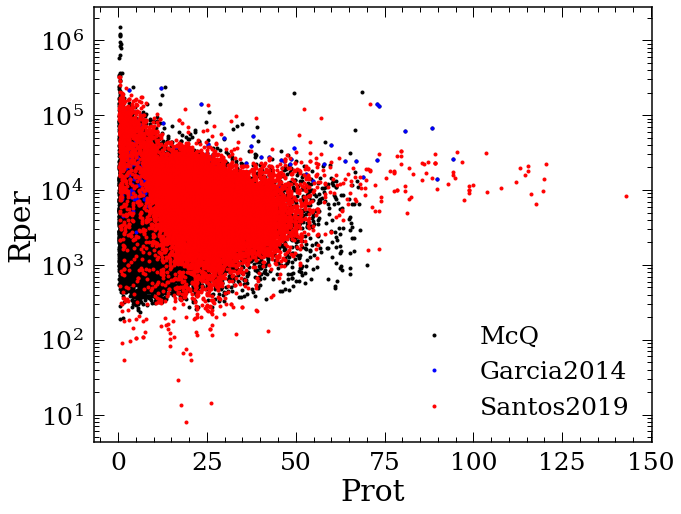

In [13]:
# read in stars from https://ui.adsabs.harvard.edu/abs/2014A%26A...572A..34G/abstract
GarsS=pd.read_csv('Garcia2014.csv')
# read in stars from https://ui.adsabs.harvard.edu/abs/2019ApJS..244...21S/abstract
SantosS=pd.read_csv('Santos2019.txt', sep=" ", header=0)
# print out the shapes
print('Garcia2014',np.shape(GarsS))
print('Santos2019',np.shape(SantosS))

df_Gars = pd.merge(GarsS, gaia, left_on="KIC", right_on="kepid", how="inner")
df_Sant = pd.merge(SantosS, gaia, left_on="KIC", right_on="kepid", how="inner")

df_Gars.rename(columns={'KIC':'KID'}, inplace=True)
df_Sant.rename(columns={'KIC':'KID'}, inplace=True)

Sph=df_Gars.Sph
Prot=df_Gars.Prot

Sph_S=df_Sant.Sph*5
Prot_S=df_Sant.Prot

df_Gars.rename(columns={'Sph':'Rper'}, inplace=True)
df_Gars.rename(columns={'e_Prot':'Prot_err'}, inplace=True)
df_Sant.Sph=df_Sant.Sph*5
df_Sant.rename(columns={'Sph':'Rper'}, inplace=True)
df_Sant.rename(columns={'e_Prot':'Prot_err'}, inplace=True)

df_Gars.drop_duplicates(subset ="KID", keep = False, inplace = True) 
df_Sant.drop_duplicates(subset ="KID", keep = False, inplace = True) 

print('Cross-matched Garcia2014',np.shape(df_Gars))
print('Cross-matched Santos2019',np.shape(df_Sant))

# merge three tables
df_Gar_Mc = pd.concat([df,df_Gars],sort="False",ignore_index=True)
df_Sant_Gar_Mc = pd.concat([df_Gar_Mc,df_Sant],sort="False",ignore_index=True)

print('Merged data shape:',np.shape(df_Sant_Gar_Mc))
print('Stars added from Garcia 2014:',np.shape(df_Gar_Mc)[0]-np.shape(df)[0])
print('Stars added from Santos 2019:',np.shape(df_Sant_Gar_Mc)[0]-np.shape(df_Gar_Mc)[0])

df_Sant_Gar_Mc.drop_duplicates(subset ="KID", keep='first', inplace = True) 


print('Origional KID length:',len(df['KID']))
print('Recovered KID from original:',np.shape(df_Sant_Gar_Mc.loc[df_Sant_Gar_Mc['KID'].isin(df['KID'])])[0])

print('Stars Added from Garcia2014 and Santos2019:',np.shape(df_Sant_Gar_Mc)[0]-np.shape(df)[0])

plt.figure(figsize=(10,8))
plt.semilogy(df_Gar_Mc.Prot,df_Gar_Mc.Rper,'k.',label='McQ')
plt.semilogy(Prot,Sph,'b.',label='Garcia2014')
plt.semilogy(Prot_S,Sph_S,'r.',label='Santos2019')
plt.legend()
plt.ylabel('Rper')
plt.xlabel('Prot')

#np.save('SantKID',df_Sant.KID)

In [14]:
# calculate vtan and vb
v_tan,v_b=CalcV(df_Sant_Gar_Mc)
# add v_b and v_tan into dataframe
df_Sant_Gar_Mc['v_b']=v_b
df_Sant_Gar_Mc['v_tan']=v_tan
df_Sant_Gar_Mc=df_Sant_Gar_Mc.reset_index(drop=True)

/Users/lucy/anaconda3/lib/python3.7/site-packages/astropy/units/equivalencies.py:90: RuntimeWarning: invalid value encountered in less
  d[d < 0] = np.nan
/Users/lucy/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/lucy/anaconda3/lib/python3.7/site-packages/astropy/coordinates/distances.py:183: RuntimeWarning: invalid value encountered in less
  if not allow_negative and np.any(distance.value < 0):
/Users/lucy/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/lucy/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/lucy/anaconda3/lib/pytho

In [15]:
TranF=np.load('TrainingFeatures.npy')
print(TranF)

['Rper' 'teff' 'bp_g' 'lum_val' 'v_tan' 'phot_g_mean_flux_over_error'
 'v_b' 'radius_val' 'b']


In [16]:
# train only on McQ stars
#TranF=['Rper']
df_Mc=df_Sant_Gar_Mc.loc[df_Sant_Gar_Mc['KID'].isin(df['KID'])].reset_index(drop=True)
regr,importance,actrualF,trainKID,testKID,predictp,avstedv=my_randF_SL(df_Mc,0.7,TranF)

regr,importance,actrualF,predictp,X_test,y_test,y_test_err,avstedv = my_randF_SL(df,traind,testF,chisq_out=0)

Fraction of data used to train: 0.7
# Features used to train: 9
Features used to train: ['Rper' 'teff' 'bp_g' 'lum_val' 'v_tan' 'phot_g_mean_flux_over_error'
 'v_b' 'radius_val' 'b']
33936 stars in dataframe!
Missing 2729 stars from null values in data!

31207 total stars used for RF!
21844 training stars!
Finished training! Making predictions!
Finished predicting! Calculating chi^2!
Average Chisq is: 1705.6281838828781
Finished!


In [17]:
# adding in Garcia2014
df_Sant_Gar_Mc['loglum_val']=np.log10(df_Sant_Gar_Mc['lum_val'])
TranF=['Rper','teff','bp_g','loglum_val','v_tan','phot_g_mean_flux_over_error','v_b','radius_val','b']
#TranF=['Rper']
newTrainKID=pd.DataFrame(np.append(np.append(trainKID,[int(i) for i in df_Gars.KID.values]),[int(i) for i in df_Sant.KID.values]),columns=['KID'])
newTrainKID.drop_duplicates(subset ="KID", keep = 'first', inplace = True)
newTrainKID=newTrainKID.iloc[:,0]
print('####################################################################################################')
print('Added # stars from Garcia2014 and Santos 2019: '+str(len(newTrainKID)-len(trainKID)))
print('Training # stars: '+str(len(newTrainKID)))
print('####################################################################################################')
# train on McQ+Garcia2014+Santos2019 stars
regr_G,importance_G,actrualF_G,trainKID_G,testKID_G,predictp_G,avstedv_G=my_randF_SL(df_Sant_Gar_Mc,0.7,TranF,newTrainKID,testKID)

####################################################################################################
Added # stars from Garcia2014 and Santos 2019: 8564
Training # stars: 30408
####################################################################################################
regr,importance,actrualF,predictp,X_test,y_test,y_test_err,avstedv = my_randF_SL(df,traind,testF,chisq_out=0)

Training KID specified!

Estimated fraction of data used to train: 0.7883234386747207
# Features used to train: 9
Features used to train: ['Rper', 'teff', 'bp_g', 'loglum_val', 'v_tan', 'phot_g_mean_flux_over_error', 'v_b', 'radius_val', 'b']
38573 stars in dataframe!
Missing 3576 stars from null values in data!

34997 total stars used for RF!
28513 training stars!
Finished training! Making predictions!
Finished predicting! Calculating chi^2!
Average Chisq is: 1502.847756889047
Finished!


# Importance on only Kepler

0
average chisq is:  1705.6281838828781


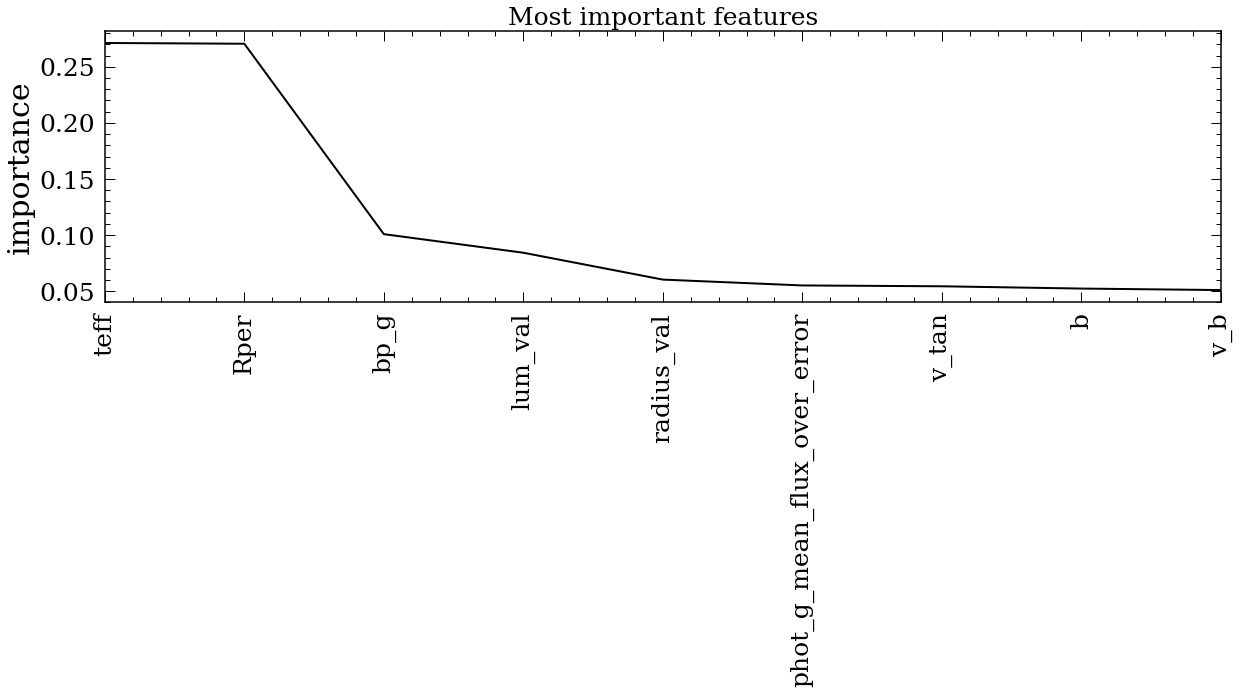

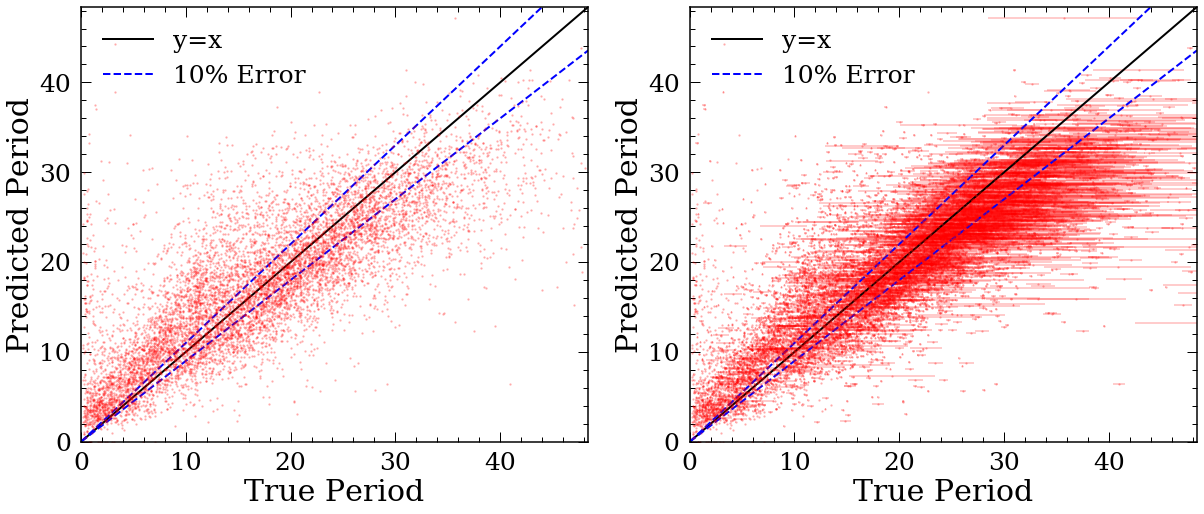

In [18]:
print(sum(testKID_G-testKID)) # should be 0 since we used the same testing set
my_xticks=plot_result(actrualF,importance,predictp,df_Mc.loc[df_Mc['KID'].isin(testKID_G)].Prot.values,df_Mc.loc[df_Mc['KID'].isin(testKID_G)].Prot_err.values)

# Importance on both

average chisq is:  1502.847756889047


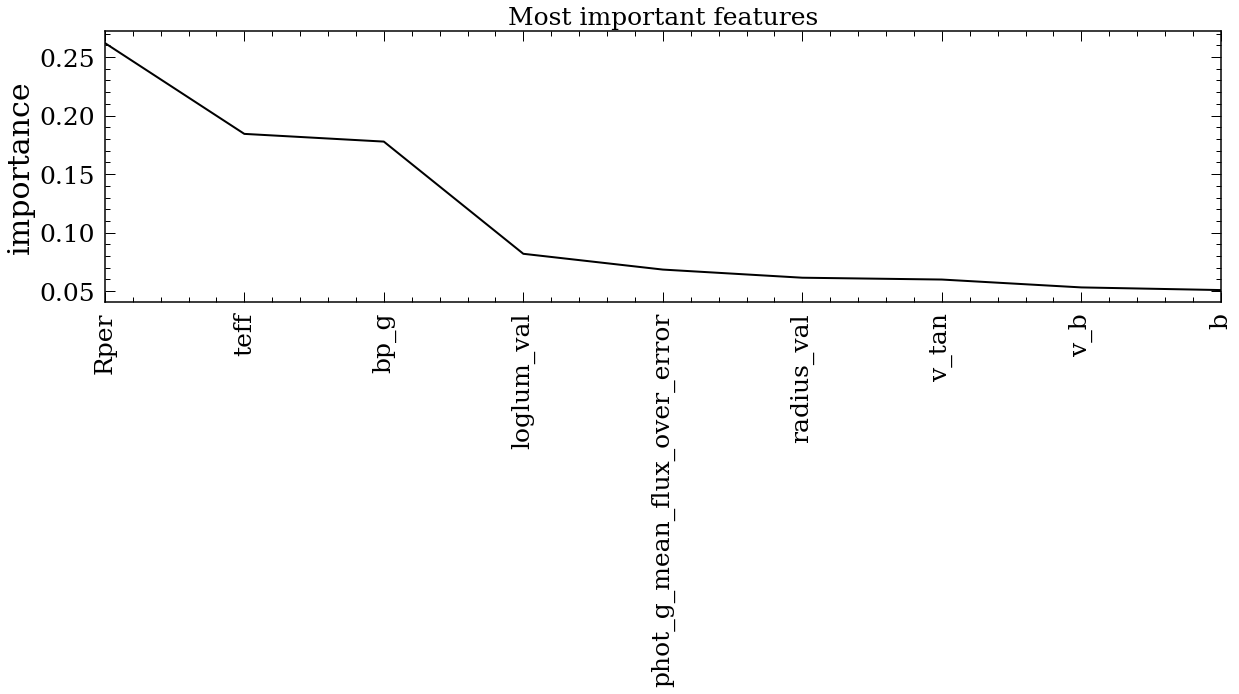

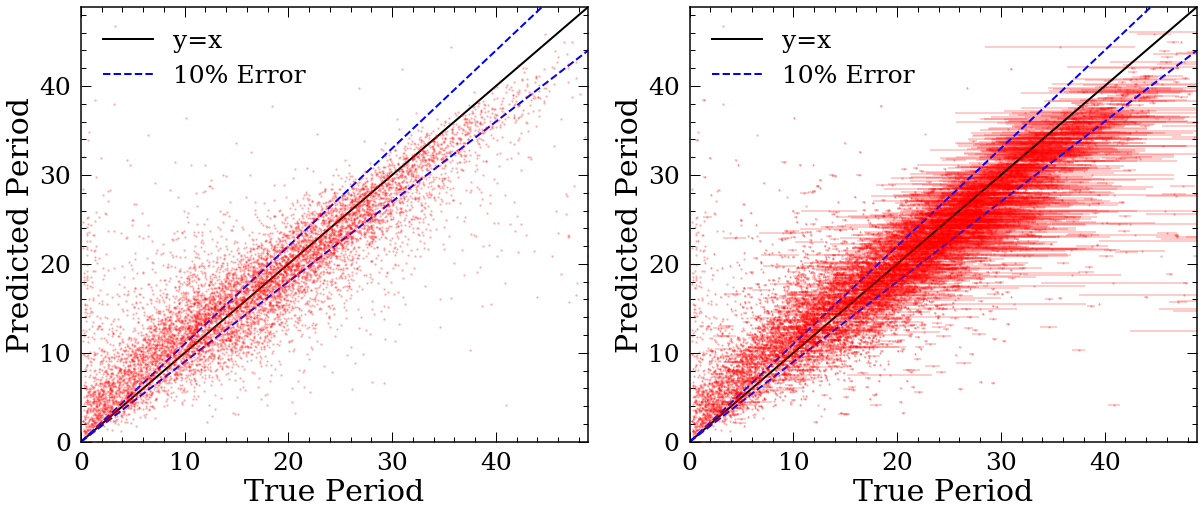

In [19]:
#print(sum(testKID_G-testKID)) # should be 0 since we used the same testing set
my_xticks=plot_result(actrualF_G,importance_G,predictp_G,df_Sant_Gar_Mc.loc[df_Sant_Gar_Mc['KID'].isin(testKID_G)].Prot.values,df_Sant_Gar_Mc.loc[df_Sant_Gar_Mc['KID'].isin(testKID_G)].Prot_err.values)

['Rper', 'teff', 'bp_g', 'loglum_val', 'phot_g_mean_flux_over_error', 'radius_val', 'v_tan', 'v_b', 'b']


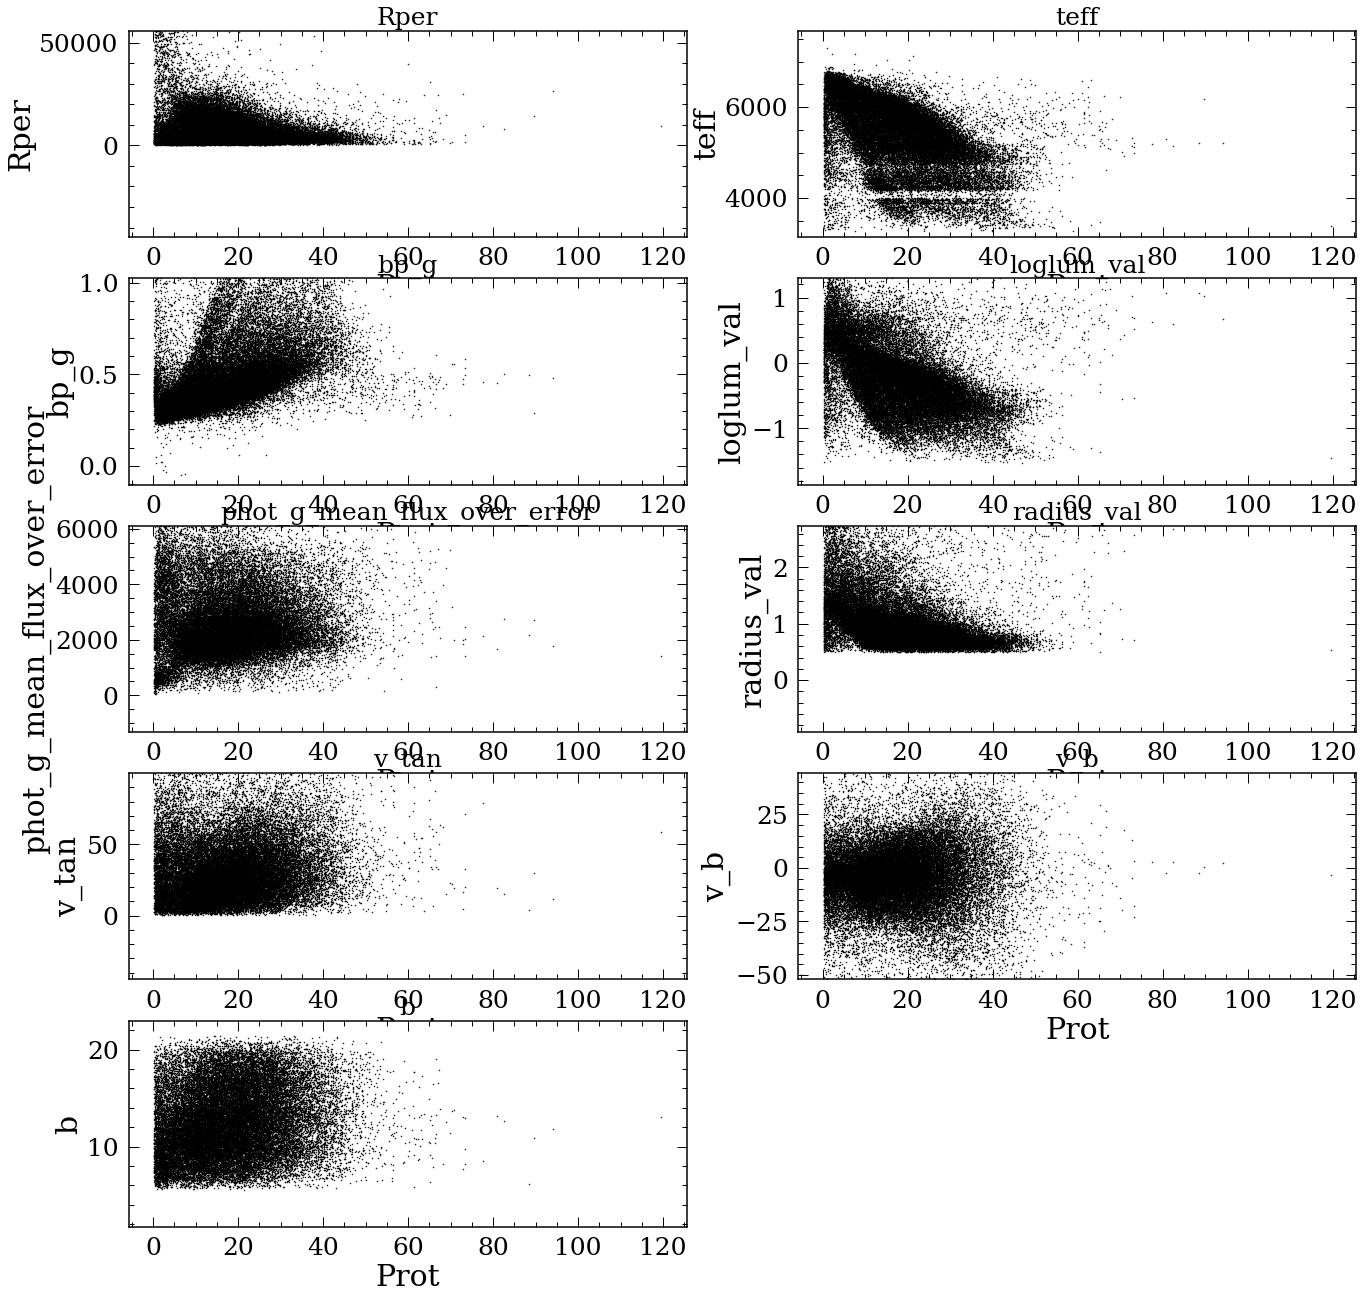

In [20]:
print(my_xticks)
plot_corr(df_Sant_Gar_Mc,my_xticks,['lum_val'],'logy')

Old chisq: 1705.6281838828781
New chisq after adding in Garcia2014: 1502.847756889047
5845 better predictions!
3502 worse predictions!


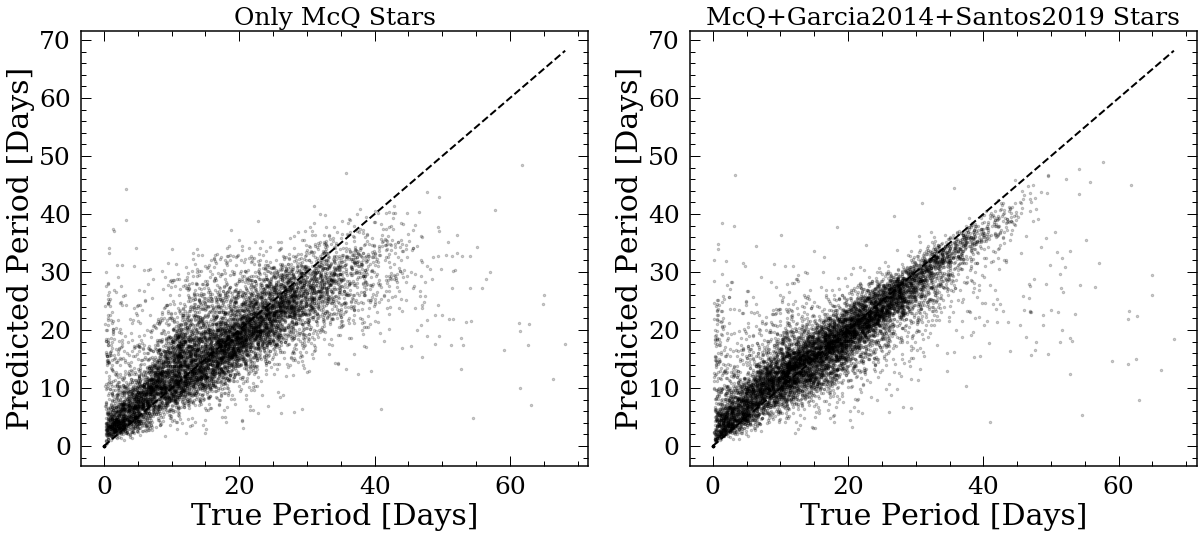

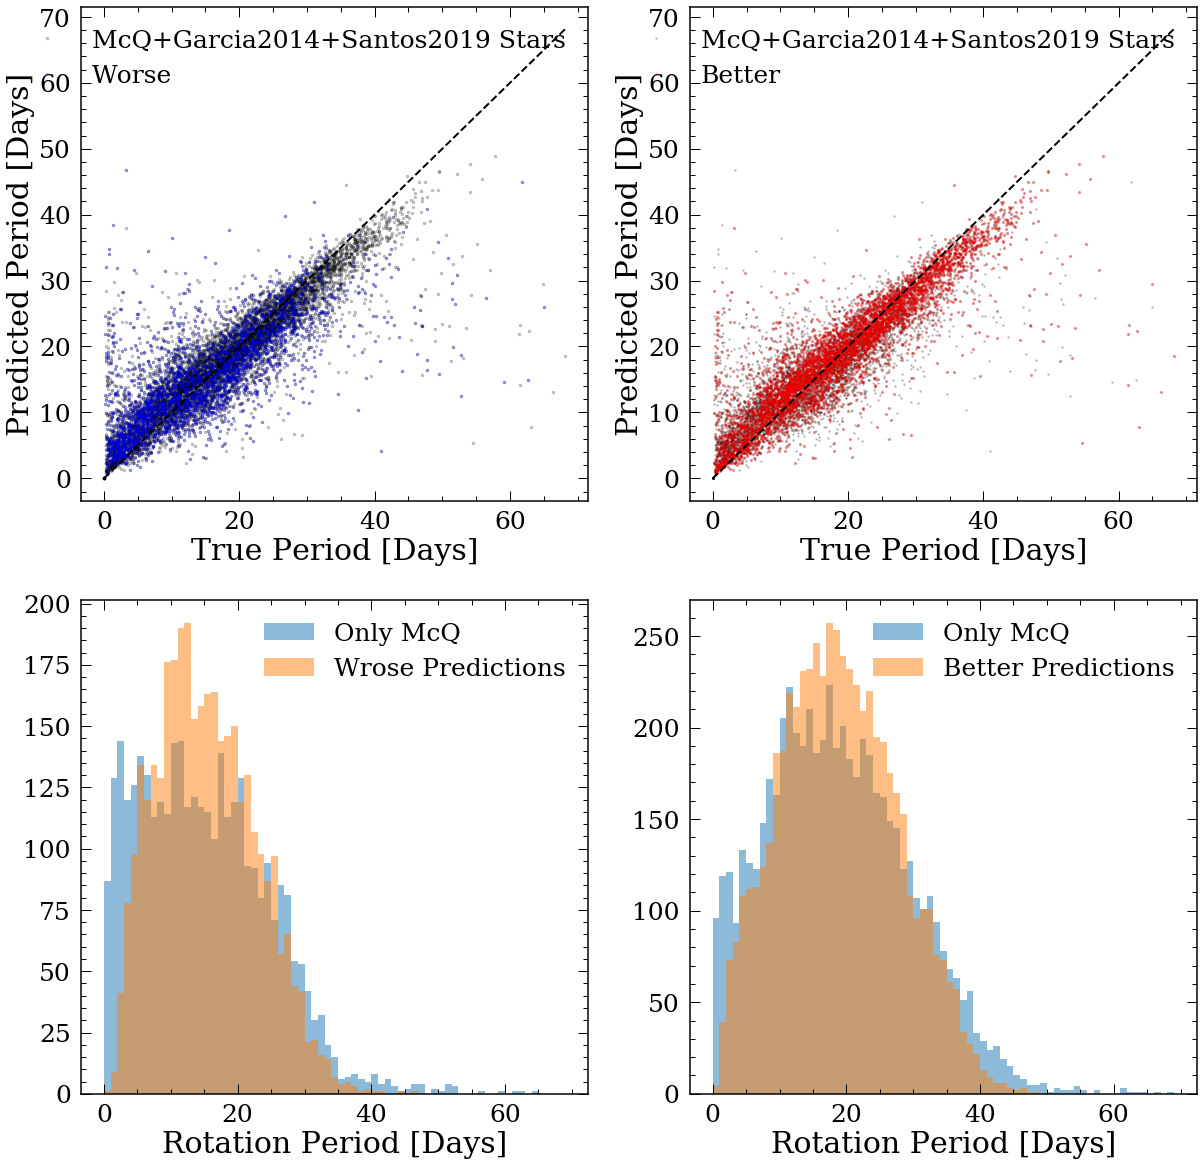

In [21]:
# plot new prediction
test_Prot=df_Sant_Gar_Mc[df_Sant_Gar_Mc['KID'].isin(testKID_G)].Prot.values
test_Prot_err=df_Sant_Gar_Mc[df_Sant_Gar_Mc['KID'].isin(testKID_G)].Prot_err.values

test_Prot_o=df_Mc.loc[df_Mc['KID'].isin(testKID_G)].Prot.values
test_Prot_err_o=df_Mc.loc[df_Mc['KID'].isin(testKID_G)].Prot_err.values


predict_Prot_n=predictp_G
predict_Prot_o=predictp
chisq_o=calcChi(test_Prot_o,predict_Prot_o,test_Prot_err_o)
chisq_n=calcChi(test_Prot,predict_Prot_n,test_Prot_err)
print('Old chisq:',chisq_o)
print('New chisq after adding in Garcia2014:',chisq_n)
# get better predictions
better_pred_ind=[]
worse_pred_ind=[]
for i in range(len(test_Prot)):
    if abs(test_Prot[i]-predict_Prot_n[i])<abs(test_Prot[i]-predict_Prot_o[i]):
        better_pred_ind.append(i)
    elif abs(test_Prot[i]-predict_Prot_n[i])>abs(test_Prot[i]-predict_Prot_o[i]):
        worse_pred_ind.append(i)


plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.title('Only McQ Stars',fontsize=25)
plt.plot(test_Prot,predict_Prot_o,'k.',markersize=5,alpha=0.2)
plt.plot(sorted(test_Prot),sorted(test_Prot),'k--')
plt.ylabel('Predicted Period [Days]')
plt.xlabel('True Period [Days]')
plt.subplot(1,2,2)
plt.title('McQ+Garcia2014+Santos2019 Stars',fontsize=25)
plt.plot(test_Prot,predict_Prot_n,'k.',markersize=5,alpha=0.2)
plt.plot(sorted(test_Prot),sorted(test_Prot),'k--')
plt.ylabel('Predicted Period [Days]')
plt.xlabel('True Period [Days]')


plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.plot(test_Prot,predict_Prot_n,'k.',markersize=5,alpha=0.2,label='McQ+Garcia2014+Santos2019 Stars')
plt.plot(test_Prot[worse_pred_ind],predict_Prot_n[worse_pred_ind],'b.',markersize=5,alpha=0.2,label='Worse') # better prediction
plt.plot(sorted(test_Prot),sorted(test_Prot),'k--')
plt.ylabel('Predicted Period [Days]')
plt.xlabel('True Period [Days]')
plt.legend()
plt.subplot(2,2,2)
plt.plot(test_Prot,predict_Prot_n,'k.',markersize=3,alpha=0.2,label='McQ+Garcia2014+Santos2019 Stars')
plt.plot(test_Prot[better_pred_ind],predict_Prot_n[better_pred_ind],'r.',markersize=5,alpha=0.2,label='Better') # better prediction
plt.plot(sorted(test_Prot),sorted(test_Prot),'k--')
plt.ylabel('Predicted Period [Days]')
plt.xlabel('True Period [Days]')
plt.legend()

bins=range(70)
plt.subplot(2,2,3)
plt.hist(test_Prot[worse_pred_ind],bins, alpha=0.5, label='Only McQ')
plt.hist(predict_Prot_n[worse_pred_ind],bins, alpha=0.5, label='Wrose Predictions')
plt.xlabel('Rotation Period [Days]')
plt.legend()
plt.subplot(2,2,4)
plt.hist(test_Prot[better_pred_ind],bins, alpha=0.5, label='Only McQ')
plt.hist(predict_Prot_n[better_pred_ind],bins, alpha=0.5, label='Better Predictions')
plt.xlabel('Rotation Period [Days]')
plt.legend()

print(len(better_pred_ind), 'better predictions!')
print(len(worse_pred_ind), 'worse predictions!')

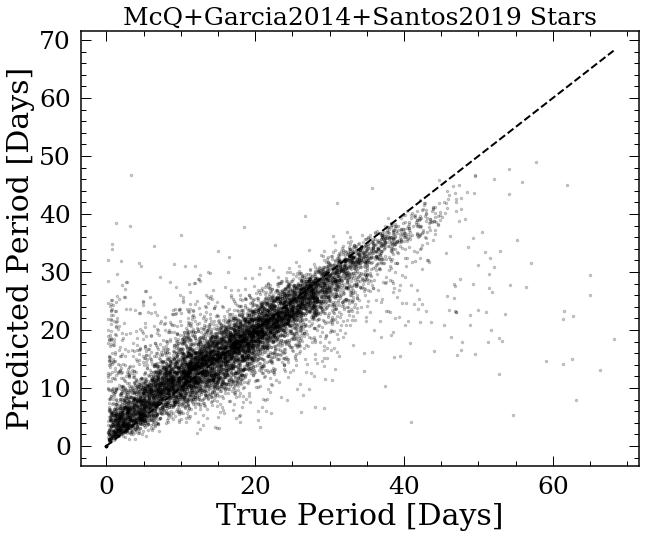

In [22]:
plt.figure(figsize=(10,8))
plt.title('McQ+Garcia2014+Santos2019 Stars',fontsize=25)
plt.plot(test_Prot,predict_Prot_n,'k.',markersize=5,alpha=0.2)
plt.plot(sorted(test_Prot),sorted(test_Prot),'k--')
plt.ylabel('Predicted Period [Days]')
plt.xlabel('True Period [Days]')
plt.savefig('RF_Prot_Update.png')

classify if we can get Prot or not?

# See if outliers are binary

Red total: 195
Blue total: 143


/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


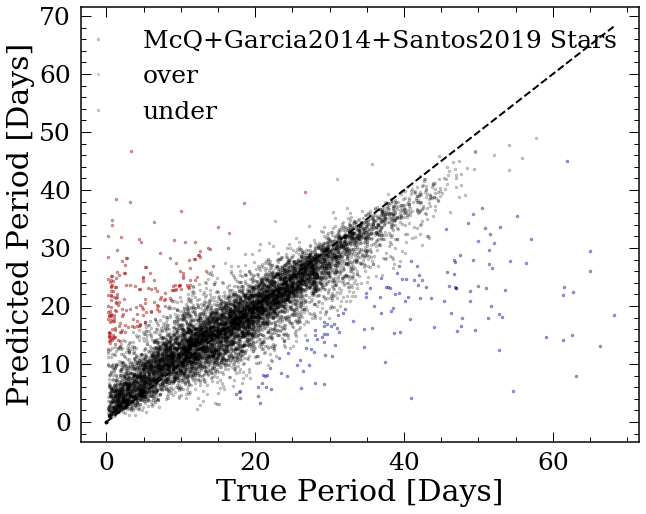

In [45]:
sh=12
sh_u=12
highProt=33

test_P_df=df_Sant_Gar_Mc[df_Sant_Gar_Mc['KID'].isin(testKID_G)]
test_P_df['P_err']=(np.squeeze(predict_Prot_n)-np.asarray(test_Prot))
P_far=test_P_df['P_err'].values
#Prot_th=test_P_df['Prot'].values

P_far_df=test_P_df.loc[test_P_df['P_err']>sh] # red
P_close_df=test_P_df.loc[test_P_df['P_err']<-sh_u] # blue
#high_Prot=test_P_df.loc[test_P_df['Prot']>highProt] # yellow

P_pred=[] # for over
P_test=[] # for over

P_pred_u=[] # for under
P_test_u=[] # for under

#P_pred_highProt=[] # for long rotation
#P_test_highProt=[] # for long rotation
for i in range(len(predict_Prot_n)):
    if P_far[i]>sh:
        P_pred.append(predict_Prot_n[i])
        P_test.append(test_Prot[i])
    elif P_far[i]<-sh_u:
        P_pred_u.append(predict_Prot_n[i])
        P_test_u.append(test_Prot[i])
        """
    if Prot_th[i]>highProt:
        P_pred_highProt.append(predict_Prot_n[i])
        P_test_highProt.append(test_Prot[i])
        """

print('Red total:',len(P_test))
print('Blue total:',len(P_test_u))
#print('Yellow total:',len(P_test_highProt))
    
plt.figure(figsize=(10,8))
plt.plot(test_Prot,predict_Prot_n,'k.',markersize=5,alpha=0.2,label='McQ+Garcia2014+Santos2019 Stars')
plt.plot(P_test,P_pred,'r.',markersize=5,alpha=0.2,label='over') # over predicting
plt.plot(P_test_u,P_pred_u,'b.',markersize=5,alpha=0.2,label='under') # under predicting
#plt.plot(P_test_highProt,P_pred_highProt,'y.',markersize=5,alpha=0.2,label='high Prot')
plt.plot(sorted(test_Prot),sorted(test_Prot),'k--')
plt.ylabel('Predicted Period [Days]')
plt.xlabel('True Period [Days]')
plt.legend()

/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


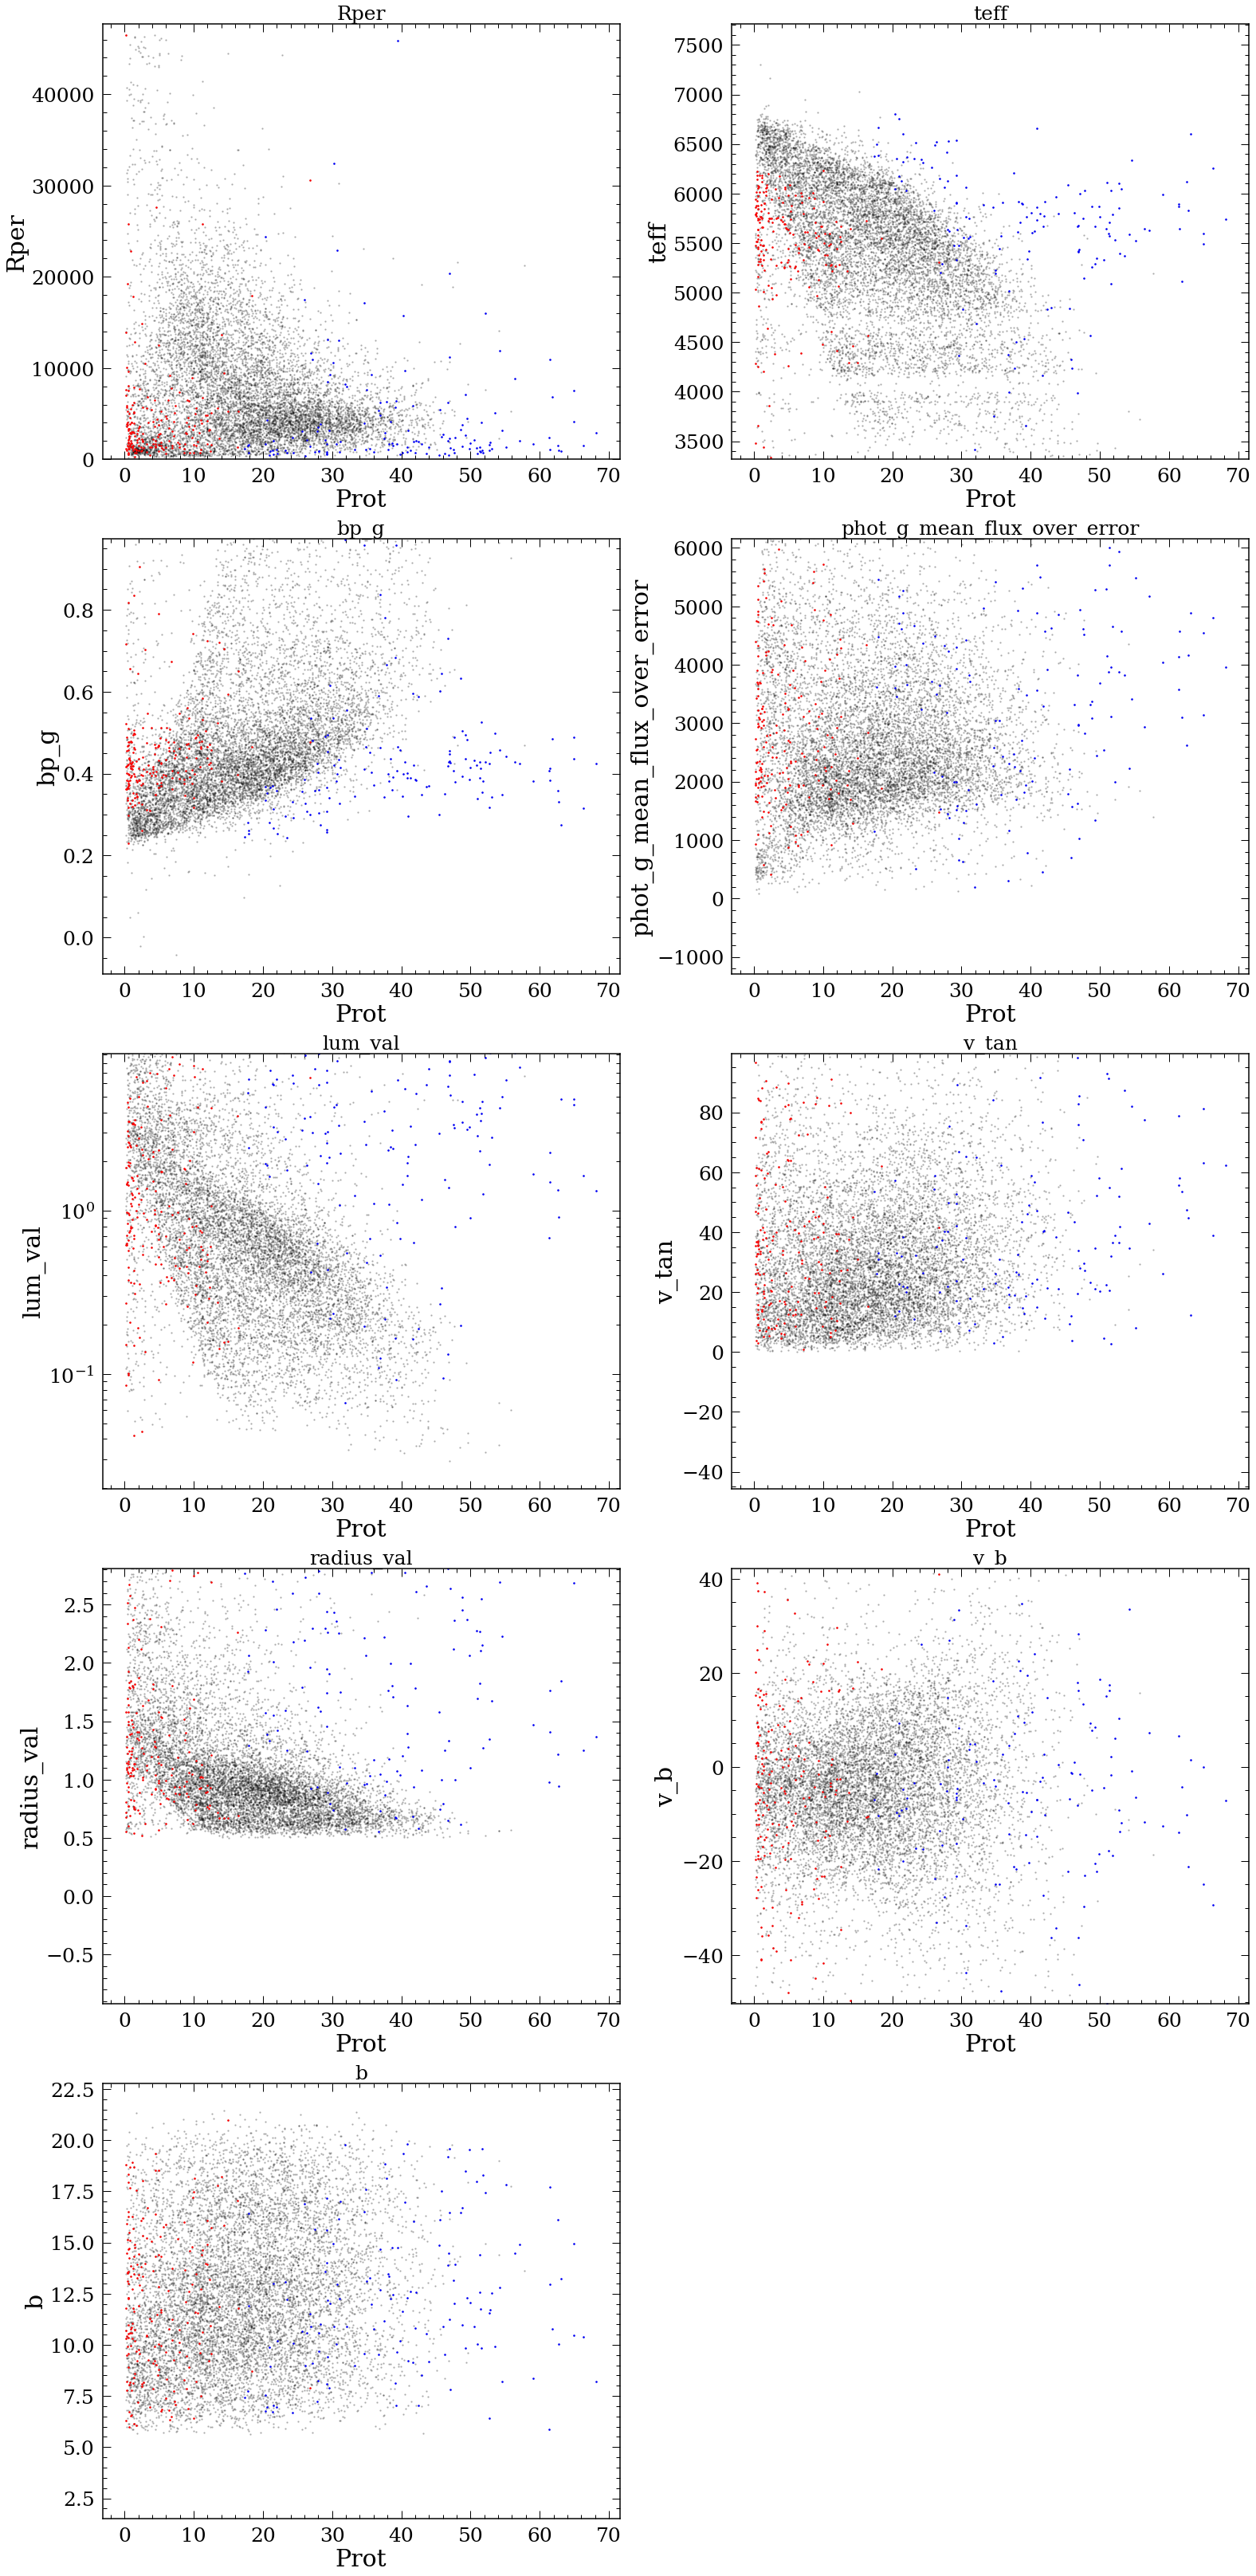

In [53]:
my_xticks=['Rper', 'teff', 'bp_g', 'phot_g_mean_flux_over_error', 'lum_val', 'v_tan', 'radius_val', 'v_b', 'b']
#################################### correlations ####################################
df=test_P_df
logplotarg=['lum_val']
logarg='logy'

# add in Prot
Prot=df.Prot # all
Prot_far=P_far_df.Prot # red
Prot_close=P_close_df.Prot # blue
#Prot_high=high_Prot.Prot # yellow

df=df[my_xticks].dropna()
Prot=Prot[df.index]
topn=len(my_xticks)
# get subplot config
com_mul=[] 
# get all multiplier
for i in range(1,topn):
    if float(topn)/float(i)-int(float(topn)/float(i))==0:
        com_mul.append(i)
        
# total rows and columns
col=int(np.median(com_mul))
row=int(topn/col)
if col*row<topn:
    if col<row:
        row=row+1
    else:
        col=col+1
        
# plot feature vs Prot
plt.figure(figsize=(int(topn*2.5),int(topn*5)))
for i in range(topn):
    plt.subplot(row,col,i+1)
    featurep=df[my_xticks[i]] # all 
    #print(my_xticks[i])
    featurep_far=P_far_df[my_xticks[i]] # red
    featurep_close=P_close_df[my_xticks[i]] # blue
    #featurep_Prot=high_Prot[my_xticks[i]] # yellow
    if my_xticks[i] in logplotarg:
        if logarg=='loglog':
            plt.loglog(Prot,featurep,'k.',alpha=0.2,markersize=3)
            plt.loglog(Prot_far,featurep_far,'r.',markersize=3)
            plt.loglog(Prot_close,featurep_close,'b.',markersize=3)
            #plt.loglog(Prot_high,featurep_Prot,'y.',markersize=3)
        elif logarg=='logx':
            plt.semilogx(Prot,featurep,'k.',alpha=0.2,markersize=3)
            plt.semilogx(Prot_far,featurep_far,'r.',markersize=3)
            plt.semilogx(Prot_close,featurep_close,'b.',markersize=3)
            #plt.semilogx(Prot_high,featurep_Prot,'y.',markersize=3)
        elif logarg=='logy':
            plt.semilogy(Prot,featurep,'k.',alpha=0.2,markersize=3)
            plt.semilogy(Prot_far,featurep_far,'r.',markersize=3)
            plt.semilogy(Prot_close,featurep_close,'b.',markersize=3)
            #plt.semilogy(Prot_high,featurep_Prot,'y.',markersize=3)
        else:
            raise SyntaxError("Log scale input not recognized!")
    else:
        plt.plot(Prot,featurep,'k.',alpha=0.2,markersize=3)
        plt.plot(Prot_far,featurep_far,'r.',markersize=3)
        plt.plot(Prot_close,featurep_close,'b.',markersize=3)
        #plt.plot(Prot_high,featurep_Prot,'y.',markersize=3)
    plt.title(my_xticks[i],fontsize=25)
    stddata=np.std(featurep)
    if my_xticks[i]=='Rper':
        plt.ylim([0,np.median(featurep)+3*stddata])
    else:
        plt.ylim([np.median(featurep)-3*stddata,np.median(featurep)+3*stddata])
    plt.xlabel('Prot')
    plt.ylabel(my_xticks[i])
    plt.tight_layout()

/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  


Text(0, 0.5, 'counts')

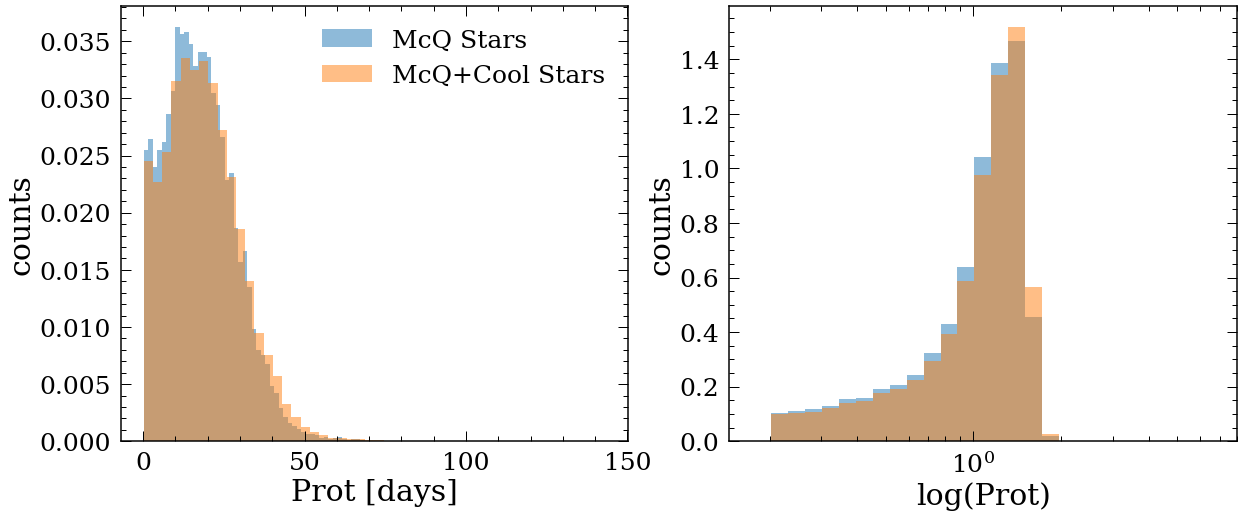

In [25]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.hist(df_Mc['Prot'].values,bins=50,alpha=0.5,density=True,label='McQ Stars')
plt.hist(df_Sant_Gar_Mc['Prot'].values,bins=50,alpha=0.5,density=True,label='McQ+Cool Stars')
plt.xlabel('Prot [days]')
plt.ylabel('counts')
plt.legend()
plt.subplot(1,2,2)
binslen=50
logbins = np.logspace(np.log10(min(df_Sant_Gar_Mc['Prot'])),np.log10(max(df_Sant_Gar_Mc['Prot'])),binslen)
plt.hist(np.log10(df_Mc['Prot'].values),bins=logbins,alpha=0.5,density=True)
plt.hist(np.log10(df_Sant_Gar_Mc['Prot'].values),bins=logbins,alpha=0.5,density=True)
plt.xscale('log')
plt.xlim([0,8])
plt.xlabel('log(Prot)')
plt.ylabel('counts')

# HR Diagram

Text(0, 0.5, 'Luminosity')

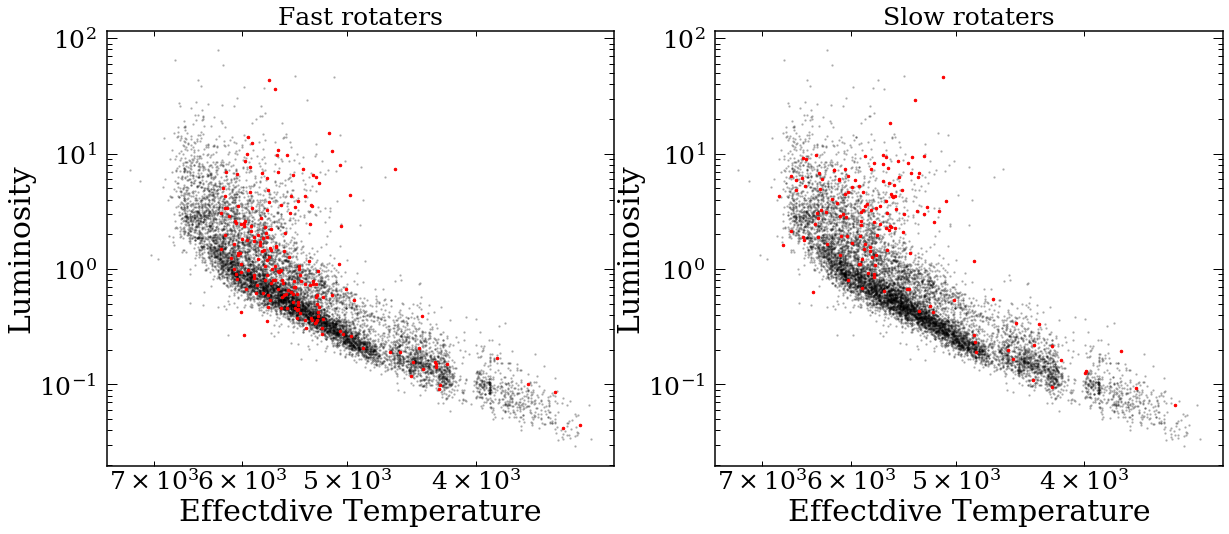

In [52]:
plt.figure(figsize=(20,8))
lum=df['lum_val'] # all 
lum_far=P_far_df['lum_val'] # red
lum_close=P_close_df['lum_val'] # blue

temp=df['teff'] # all 
temp_far=P_far_df['teff'] # red
temp_close=P_close_df['teff'] # blue
    
plt.subplot(1,2,1)
#plt.plot(temp,Prot,'k.',alpha=0.2,markersize=3)
#plt.plot(temp_far,Prot_far,'r.',markersize=3)
#plt.plot(temp_close,Prot_close,'b.',markersize=3)
plt.loglog(temp,lum,'k.',alpha=0.2,markersize=3)
plt.loglog(temp_far,lum_far,'r.',markersize=5)
plt.gca().invert_xaxis()
plt.title('Fast rotaters',fontsize=25)
plt.xlabel('Effectdive Temperature')
plt.ylabel('Luminosity')

plt.subplot(1,2,2)
plt.loglog(temp,lum,'k.',alpha=0.2,markersize=3)
plt.loglog(temp_close,lum_close,'r.',markersize=5)
plt.gca().invert_xaxis()
plt.title('Slow rotaters',fontsize=25)
plt.xlabel('Effectdive Temperature')
plt.ylabel('Luminosity')



# Download lightcurves

In [ ]:
import time, sys
from IPython.display import clear_output
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)
    
KIDdown=np.load('SantKID.npy')
print(len(KIDdown))
import kplr # with pip install needed to change async into async_ for python 3.7...
import random
client = kplr.API("/Volumes/LaCie/KeplerLC")
# pick out # of stars
samplesize=501
start=9500
KID_a = KIDdown[start:start+samplesize] # list of KID
#print(KID_a)
for i in range(len(KID_a)):
    update_progress(i/len(KID_a))
    KID=KID_a[i]
    star = client.star(str(KID))
    #print(star)
    star.get_light_curves(fetch=True, short_cadence=False)

Progress: [#############-------] 66.0%


In [29]:
#df_Sant_Gar_Mc.to_pickle('Mc_Gar_Sant')
df_Sant_Gar_Mc=pd.read_pickle('Mc_Gar_Sant')
df_Sant_Gar_Mc

,CP/CB_candidate_flag,DC,E_M,E_Teff,E_logg,FQ,Flag,FliPer_Class,GAIA_inary_flag,GAIA_subgiant_flag,...,teff_percentile_lower,teff_percentile_upper,teff_prov,teff_val,tm_designation,visibility_periods_used,w,v_b,v_tan,loglum_val
0,NaN,0.0,NaN,NaN,NaN,NaN,---,NaN,NaN,NaN,...,3605.000000,4485.666504,KIC0,3765.000000,2MASS J19241533+3638089,15.0,0.4503,-23.237122,43.610090,-0.349625
1,NaN,0.0,NaN,NaN,NaN,NaN,---,NaN,NaN,NaN,...,4398.880371,4705.450195,PHO1,4424.760254,2MASS J19241682+3646501,15.0,0.7229,2.149538,11.256302,NaN
2,NaN,0.0,NaN,NaN,NaN,NaN,---,NaN,NaN,NaN,...,3928.000000,4284.449707,KIC0,4109.000000,2MASS J19243578+3643257,16.0,0.6061,15.602643,17.702679,-0.973228
3,NaN,1.0,NaN,NaN,NaN,NaN,---,NaN,NaN,NaN,...,3730.750000,4269.720215,PHO2,3823.333252,2MASS J19252036+3648231,15.0,0.5445,-11.929150,20.490185,-0.847908
4,NaN,0.0,NaN,NaN,NaN,NaN,---,NaN,NaN,NaN,...,3956.135010,4525.220215,PHO1,4239.220215,2MASS J19263622+3650126,15.0,0.3939,13.596025,17.989548,-0.995518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38568,1.0,NaN,0.027,67.0,0.036,17.0,NaN,2.0,0.0,0.0,...,3724.250000,3969.459961,PHO2,3774.500000,2MASS J19214456+5210410,17.0,NaN,-3.861716,9.081078,-0.826146
38569,-999.0,NaN,0.059,136.0,0.025,17.0,NaN,0.0,0.0,0.0,...,4943.333496,5107.000000,PHO1,4995.666504,2MASS J19182351+5213445,15.0,NaN,-1.212178,3.229439,-0.465754
38570,-999.0,NaN,0.051,150.0,0.032,17.0,NaN,0.0,0.0,0.0,...,4168.556641,4485.220215,KIC0,4307.020020,2MASS J19185484+5212276,17.0,NaN,-35.372596,68.123474,-0.905038
38571,-999.0,NaN,0.062,164.0,0.099,17.0,NaN,0.0,0.0,0.0,...,4682.700195,4853.950195,PHO1,4745.840332,2MASS J19204780+5214565,16.0,NaN,6.894063,8.393855,-0.506828
